In [1]:
# import packages

import scipy.io as sio  # for loading matlab data

import numpy as np      # for numerical libs

from matplotlib.ticker import FuncFormatter # for custom bar plot labels

import matplotlib.pyplot as plt  # for plotting

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
from statsmodels.tsa import stattools
from statsmodels.graphics import gofplots
from scipy import stats
from statsmodels.tsa import arima_model
from statsmodels.regression import linear_model
from os import path

Part 1: Estimate the coefficient of a linear price impact function and deduce the risk-aversion of the market maker from it

In [3]:
# Loop through files to get all data from Nov3 - Nov26
# Define function to return parameters: a) midprices and order flow b) Heights of LOB

def getPF(ticker, start, end):
    # presumption: must have the 'Nov-2014' data folder in the working directory
    ''' startTime = 10*60*30 #10:00 (30mins after open)
    endTime = 10*60*60*6 #15:30 (30mins before close)'''
    
    P = np.array([])
    volMO = np.array([])
    Pa3s = np.array([])
    Pb3s = np.array([])
    askvolSum = np.array([])
    bidvolSum = np.array([])
    for day in range(start,end+1):
        dateStr = f"{day:02}"
        file = 'Nov-2014/' + ticker +'_201411' + dateStr + '.mat'
        if path.exists(file):
            data = sio.loadmat(file)
            LOB=data['LOB']
            ask = np.array(LOB['SellPrice'][0][0]*1e-4)
            askvol = np.array(LOB['SellVolume'][0][0]*1.0)
            bid = np.array(LOB['BuyPrice'][0][0]*1e-4)
            bidvol = np.array(LOB['BuyVolume'][0][0]*1.0)
            vMO = np.array(LOB['VolumeMO'][0][0]*1.0)

            Pa3s = np.append(Pa3s, ask[:,2])
            Pb3s = np.append(Pb3s, bid[:,2])
            midprice = 0.5*(bid[:,0]+ask[:,0])
            P = np.append(P, midprice)
            volMO = np.append(volMO, vMO[:,0]-vMO[:,1])
            askvolSum = np.append(askvolSum, np.sum(askvol[:,0:3],axis=1))
            bidvolSum = np.append(bidvolSum, np.sum(bidvol[:,0:3],axis=1))

    OF = np.cumsum(volMO)
    Ha = askvolSum / (Pa3s - P)
    Hb = bidvolSum / (P - Pb3s)
    return P, OF, Ha, Hb

In [4]:
# get MSFT parameters
Pms, OF, Ha, Hb = getPF('MSFT',3,26)

# a) Estimate price impact coefficient using the midprice and orderflow
# get values at the start of every second
P2 = Pms[::10]
OF2 = OF[::10]
slope, intercept, r_value, p_value, std_err = stats.linregress(np.diff(OF2), np.diff(P2))
MSFTa = slope
print('impact(slope):', slope)
print('intercept:', intercept)
print(p_value)

# b) estimate price impact coefficient via LOB
lambdas = (1/Ha + 1/Hb)/2
MSFTb = np.mean(lambdas)
print('impact(LOB):', MSFTb)

impact(slope): 8.516535910053103e-07
intercept: -5.1032892281204695e-06
0.0
impact(LOB): 1.599593907717814e-06


In [5]:
# get GOOG parameters
Pgg, OF, Ha, Hb = getPF('GOOG',3,26)

# a) Estimate price impact coefficient using the midprice and orderflow
# get values at the start of every second
P2 = Pgg[::10]
OF2 = OF[::10]
slope, intercept, r_value, p_value, std_err = stats.linregress(np.diff(OF2), np.diff(P2))
GOOGa = slope
print('impact(slope):', slope)
print('intercept:', intercept)
print(p_value)

# b) estimate price impact coefficient via LOB
lambdas = (1/Ha + 1/Hb)/2
GOOGb = np.mean(lambdas)
print('impact(LOB):', GOOGb)

impact(slope): 0.00011410857525993758
intercept: -5.809990990859403e-05
0.0
impact(LOB): 0.0005758615962403105


In [6]:
# c) calculate the risk-aversion of the market maker

# approximate fundamental vals from midprice variance
h = 10*60*5 #number of timestamps in 5 mins
VARms = np.var(np.diff(Pms[::h]))
VARgg = np.var(np.diff(Pgg[::h]))
print('MSFT Var:', VARms)
print('GOOG Var:', VARgg)
print()

# Risk Aversion
RA_MSFT_a = MSFTa/(2*VARms)
RA_MSFT_b = MSFTb/(2*VARms)
RA_GOOG_a = GOOGa/(2*VARgg)
RA_GOOG_b = GOOGb/(2*VARgg)

print('Risk Aversion')
print('MSFT:')
print('a)', RA_MSFT_a)
print('b)', RA_MSFT_b)
print('GOOG:')
print('a)', RA_GOOG_a)
print('b)', RA_GOOG_b)

MSFT Var: 0.002497142336780609
GOOG Var: 0.3577849575469325

Risk Aversion
MSFT:
a) 0.00017052564014097965
b) 0.0003202848880813215
GOOG:
a) 0.00015946530569968046
b) 0.0008047593730443122


Part 2: Implement trading strategy based on predicting prices via order flow

In [2]:
# Load data
data = sio.loadmat('Nov-2014/MSFT_20141103.mat')
LOB = data['LOB']

t = (np.array((LOB['EventTime'][0][0][:,0]))-3600000*9.5)*1e-3 #time in seconds, measured from NASDAQ opening at 9:30am
bid = np.array(LOB['BuyPrice'][0][0]*1e-4)
bidvol = np.array(LOB['BuyVolume'][0][0]*1.0)
ask = np.array(LOB['SellPrice'][0][0]*1e-4)
askvol = np.array(LOB['SellVolume'][0][0]*1.0)
nMO = np.array(LOB['NumberMO'][0][0]*1.0)
vMO = np.array(LOB['VolumeMO'][0][0]*1.0)
MO=np.array(LOB['MO'][0][0]*1.0)
dt = t[1]-t[0]
OF = np.cumsum(vMO[:,0]-vMO[:,1])
midprice = 0.5*(bid[:,0]+ask[:,0])

In [3]:
# Define hyper parameters and function to extract parameters from running window

q = 100
estWin = 10*60*10 #10 mins
K = 10*60*3 #3 mins (timestamps of prediction interval)
tP = 0.02999
lP = 0.03999
p_upper = 0.05
rho_lower = 0.02
R_lower = 0.7

def getParams(startT):
    t_win = list(t[startT-estWin:startT]-t[startT-estWin])[::10]
    OF_win = list(OF[startT-estWin:startT]-OF[startT-estWin])[::10]
    P_win = list(midprice[startT-estWin:startT])[::10]
    #print(len(t_win), len(OF_win), len(P_win))
    slope, intercept, r_val, p_val, std_err = stats.linregress(t_win,OF_win)
    a = intercept
    b = slope
    OF_centered = [(OF_win[i] - t_win[i]*b - a) for i in range(len(OF_win))]
    phi, sigma = linear_model.yule_walker(OF_centered,order=1)
    rho = 1 - phi
    
    OF_diff = np.diff(OF_win)
    P_diff = np.diff(P_win)
    #print(OF_diff.shape, P_diff.shape)
    slope, intercept, R, p2, std_err = stats.linregress(OF_diff, P_diff)
    impact = slope 
    P_diff_cen = [(P_diff[i] - OF_diff[i]*impact - intercept) for i in range(len(P_diff))]
    my_DF = stattools.adfuller(P_diff_cen,1,'c',None)
    p1 = my_DF[1]

    return p1, p2, R, impact, a, b, rho, OF_centered[-1], sigma
    

In [4]:
# Loop through every point in time t, carrying out our strategy

# set parameters
shares = [0]
PnL = [0]
startTime = 10*60*40 #10:10 (40mins after open)
endTime = 10*60*60*6 #15:30 (30mins before close)
maxHoldingTime = 0
targetPrice = 0
lossPrice = 0
F_upper = 0
a, b, t0 = 0, 0, 0

for time in range(startTime, endTime):
    shares.append(shares[-1])
    PnL.append(PnL[-1])
    if time%10000 == 0:
        print('time:', time)
    if shares[-1] == 0:
        p1, p2, R, impact, a, b, rho, Fm, sigma = getParams(time)

        # if conditions are met, open a position
        if p1<p_upper and p2<p_upper and rho>rho_lower and R>R_lower:
            # predicted change in midprice
            dP = impact*b*K/10 + impact*Fm*((1-rho)**(K/10)-1)-impact*sigma
            F_lower = 1.3 * sigma
            F_upper = 2 * sigma
            t0 = time
            maxHoldingTime = time + K
            if dP >= tP and Fm > -F_lower:
                targetPrice = ask[time,0] + tP
                lossPrice = ask[time,0] - lP
                shares[-1] += q 
                PnL[-1] -= q*bid[time,0]
            elif dP <= tP and Fm < F_lower:
                targetPrice = bid[time,0] - tP
                lossPrice = bid[time,0] + lP
                shares[-1] -= q 
                PnL[-1] += q*ask[time,0]
    else:
        if shares[-1]>0: # close long position if conditions are met
            if ask[time,0] >= targetPrice:
                shares[-1] -= q
                PnL[-1] += q*(ask[time,0] - 0.01)
            elif bid[time,0] <= lossPrice:
                shares[-1] -= q
                PnL[-1] += q*lossPrice
            elif time > maxHoldingTime:
                shares[-1] -= q
                PnL[-1] += q*bid[time,0]
            elif OF[time] - a - b*(time-t0+estWin)/10 < -F_upper:
                shares[-1] -= q
                PnL[-1] += q*bid[time,0]

        if shares[-1]<0: # close Short position if conditions are met
            if bid[time,0] <= targetPrice:
                shares[-1] += q
                PnL[-1] -= q*(bid[time,0] + 0.01)
            elif ask[time,0] >= lossPrice:
                shares[-1] += q
                PnL[-1] -= q*lossPrice
            elif time > maxHoldingTime:
                shares[-1] += q
                PnL[-1] -= q*ask[time,0]
            elif OF[time] - a - b*(time-t0+estWin)/10 > F_upper:
                shares[-1] += q
                PnL[-1] -= q*ask[time,0]
    

time: 30000
time: 40000
time: 50000
time: 60000
time: 70000
time: 80000
time: 90000
time: 100000
time: 110000
time: 120000
time: 130000
time: 140000
time: 150000
time: 160000
time: 170000
time: 180000
time: 190000
time: 200000
time: 210000


In [5]:
# save PnL process
np.savetxt('Abs_PnL.csv', np.array(PnL), delimiter=',')

Text(0, 0.5, 'USD')

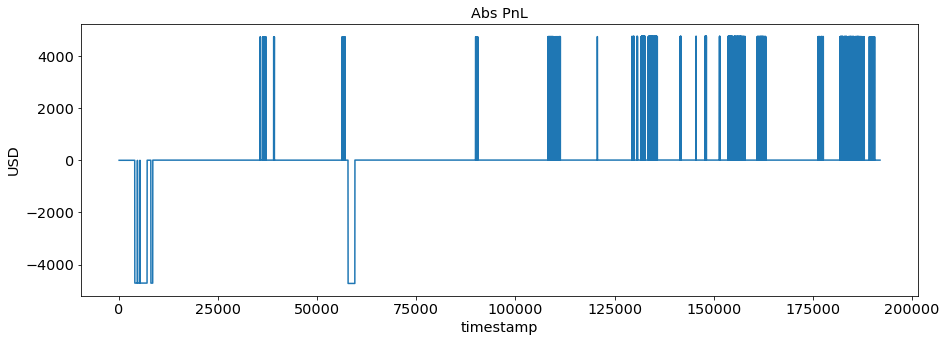

In [184]:
# Plot the PnL process
plt.plot(PnL)
plt.title('Abs PnL')
plt.xlabel('timestamp')
plt.ylabel('USD')

Gross Profit: 6.001000000002023


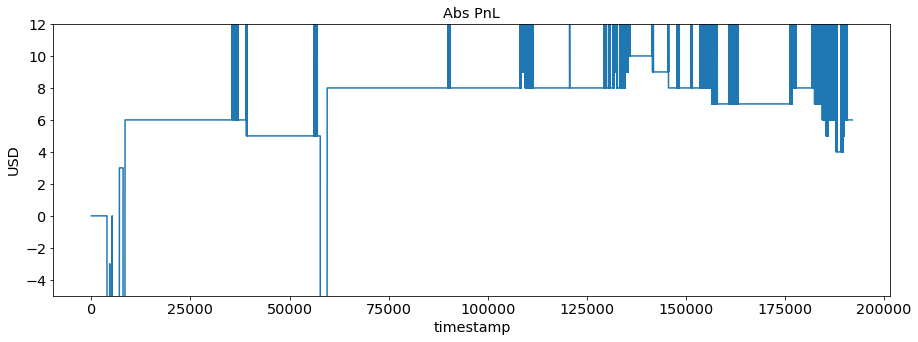

In [189]:
# Zoom in 
plt.plot(PnL)
plt.title('Abs PnL')
plt.xlabel('timestamp')
plt.ylabel('USD')
plt.ylim(-5,12)

# Final Profit
print('Gross Profit:', PnL[-1])

Text(0.5, 0, 'timestamp')

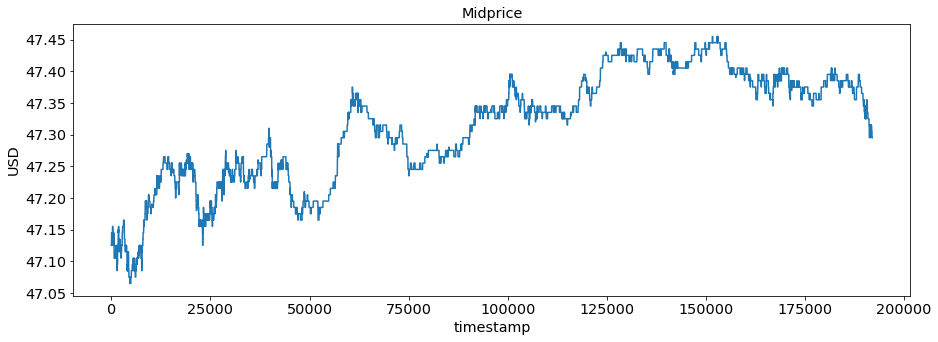

In [192]:
# Visualizing midprice for reference
plt.plot(midprice[startTime:endTime])
plt.title('Midprice')
plt.ylabel('USD')
plt.xlabel('timestamp')